In [63]:
from model.residual_attention_network import ResidualAttentionModel_92_32input_update as ResidualAttentionModel

In [64]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.Pad(padding=2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='./data_mnist_train',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = datasets.FashionMNIST(
    root='./data_mnist_test',
    train=False,
    download=True,
    transform=transform_train
)

In [65]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [66]:
images, labels = next(iter(train_loader))
# 64, 1, 28, 28
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])


In [67]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

In [68]:
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = next(data_iter)

In [69]:
def show_images_with_labels(images, labels):
    fig = plt.figure(figsize=(10, 4))
    for idx in range(5):
        print(images[idx].shape)
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx][0].squeeze(), cmap='gray')
        ax.set_title(class_names[labels[idx].item()])
    plt.show()

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


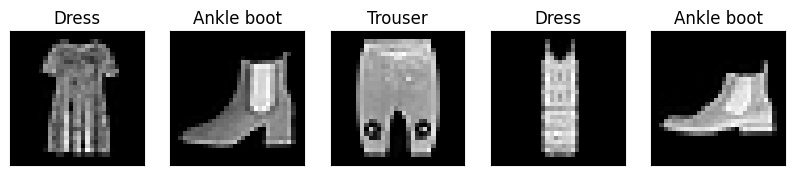

In [70]:
show_images_with_labels(images, labels)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualAttentionModel().to(device)
# print(model)

lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=lr
)

total_epochs = 10
best_acc = 0.0
loss_history = [[] for x in range(total_epochs)]
loss_history_test = [[] for x in range(total_epochs)]
history = []
# history = [{} for x in range(total_epochs)]

for epoch in range(total_epochs):
    model.train()
    epoch_start = time.time()
    running_loss = 0.0
    val_loss = 0.0
    total_train = 0
    correct_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs}", leave=False)

    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_train += images.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history[epoch].append(loss.item())
        train_loop.set_postfix(loss=loss.item())

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            test_loss = criterion(outputs, labels)
            loss_history_test[epoch].append(test_loss.item())
            val_loss += test_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    train_acc = 100 * correct_train / total_train

    epoch_time = time.time() - epoch_start
    history.append(
        {
            'loss': running_loss / len(train_loader),
            'val_loss': val_loss / len(train_loader),
            'train_acc': train_acc,
            'val_acc': val_acc,
            'epoch_time': epoch_time,
        }
    )
    print(
        f"Epoch [{epoch + 1}/{total_epochs}] | "
        f"Loss: {running_loss / len(train_loader):.4f} | "
        f"Val Acc: {val_acc:.2f}% | "
        f"Time: {epoch_time:.2f}s"
    )

Epoch [1/10] | Loss: 0.4608 | Val Acc: 90.15% | Time: 143.32s


Epoch [2/10] | Loss: 0.2502 | Val Acc: 90.17% | Time: 146.27s


Epoch [3/10] | Loss: 0.2062 | Val Acc: 91.49% | Time: 141.21s


Epoch [4/10] | Loss: 0.1713 | Val Acc: 92.56% | Time: 141.71s


Epoch [5/10] | Loss: 0.1484 | Val Acc: 90.85% | Time: 143.28s


Epoch [6/10] | Loss: 0.1247 | Val Acc: 92.96% | Time: 145.38s


Epoch [7/10] | Loss: 0.1034 | Val Acc: 92.53% | Time: 146.24s


Epoch [8/10] | Loss: 0.0889 | Val Acc: 92.22% | Time: 146.82s


Epoch [9/10] | Loss: 0.0728 | Val Acc: 92.70% | Time: 139.18s


Epoch [10/10] | Loss: 0.0613 | Val Acc: 92.38% | Time: 140.17s


In [37]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'val_loss', 'train_acc', 'val_acc', 'epoch_time'])


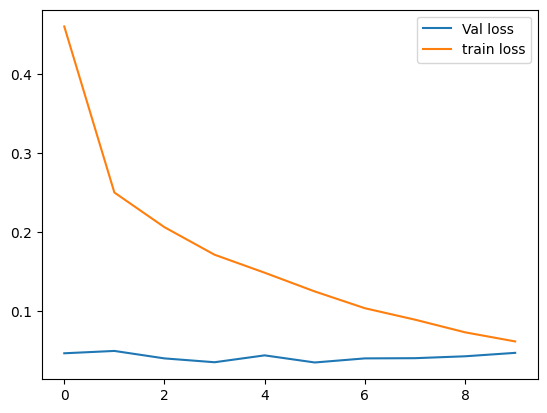

In [40]:
print(history[0].keys())
val_loss_ = [history[x]['val_loss'] for x in range(10)]
train_loss_ = [history[x]['loss'] for x in range(10)]

plt.figure()
plt.plot(val_loss_, label='Val loss')
plt.plot(train_loss_, label='train loss')
plt.legend()

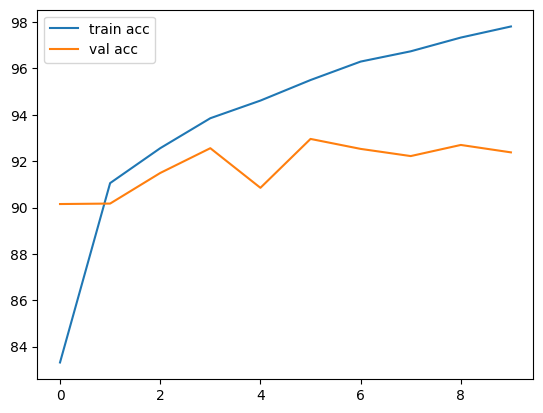

In [45]:
train_acc_ = [history[x]['train_acc'] for x in range(10)]
val_acc_ = [history[x]['val_acc'] for x in range(10)]

plt.figure()
plt.plot(train_acc_, label='train acc')
plt.plot(val_acc_, label='val acc')
plt.legend()


In [46]:
from datetime import datetime

now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H:%M:%S")

In [50]:
name = "ResidualAttentionModel_92_32input_update_"+timestamp+".pth"
path = "./weights/" + name
torch.save(model.state_dict(), path)

In [52]:
from pathlib import Path
path = "./results/ResidualAttentionModel_92_32input_update_"+timestamp
Path(path).mkdir(parents=True, exist_ok=True)

In [54]:
import pickle

with open(path + "/history.pickle", 'wb') as f:
    pickle.dump(history, f)

with open(path + "/loss_history.pickle", 'wb') as f:
    pickle.dump(loss_history, f)

with open(path + "/loss_history_test.pickle", 'wb') as f:
    pickle.dump(loss_history_test, f)

In [55]:
test_iter = iter(test_loader)

In [60]:
img, label = next(test_iter)
img, label = img.to(device), label.to(device)

result = model(img)

In [73]:
_, predicted = torch.max(result.data, 1)
print(predicted)

tensor([1, 5, 4, 1, 9, 1, 8, 6, 6, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 2, 4, 4,
        1, 4, 5, 0, 4, 7, 9, 3], device='cuda:0')


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


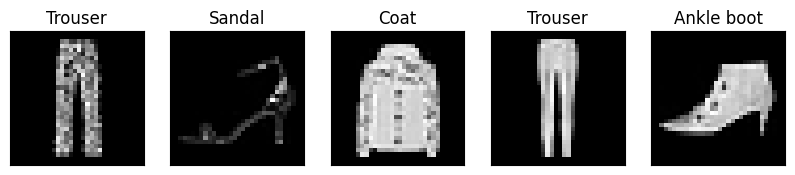

In [72]:
show_images_with_labels(img.to('cpu'), label.to('cpu'))

In [88]:
def show_images_with_labels_predicted(images, labels, result):
    fig = plt.figure(figsize=(18, 6))
    _, predicted = torch.max(result.data, 1)
    for idx in range(5):
        print(images[idx].shape)
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx][0].squeeze(), cmap='gray')
        ax.set_title(f"T: {class_names[labels[idx].item()]}, P: {class_names[predicted[idx].item()]}")
    plt.show()

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


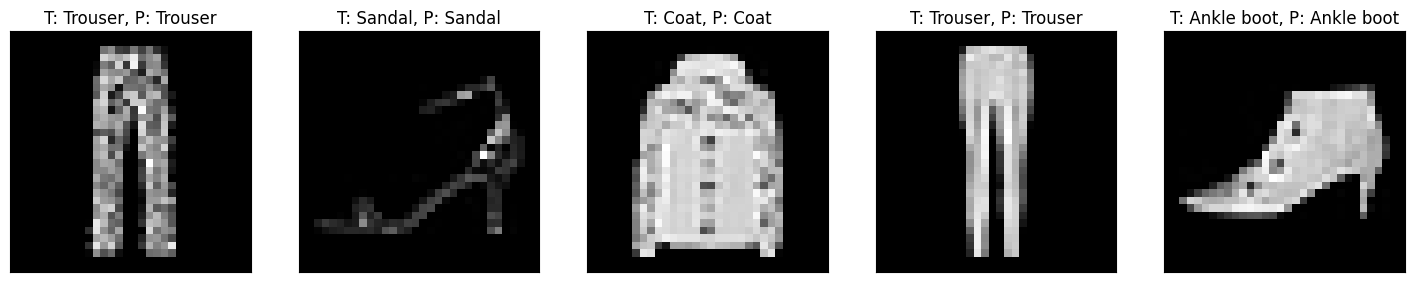

In [89]:
show_images_with_labels_predicted(img.to('cpu'), label.to('cpu'), result.to('cpu'))

In [17]:
# from __future__ import print_function, division
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.autograd import Variable
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# import torchvision
# from torchvision import transforms, datasets, models
# import os
# import cv2
# import time
# # from model.residual_attention_network_pre import ResidualAttentionModel
# # based https://github.com/liudaizong/Residual-Attention-Network
# from temp.model.residual_attention_network import ResidualAttentionModel_92_32input_update as ResidualAttentionModel
#
# model_file = './temp/model_92_sgd.pkl'
#
#
# # for test
# def test(model, test_loader, btrain=False, model_file='./temp/model_92_sgd.pkl'):
#     # Test
#     if not btrain:
#         model.load_state_dict(torch.load(model_file))
#     model.eval()
#
#     correct = 0
#     total = 0
#     #
#     class_correct = list(0. for i in range(10))
#     class_total = list(0. for i in range(10))
#
#     for images, labels in test_loader:
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels.data).sum()
#         #
#         c = (predicted == labels.data).squeeze()
#         for i in range(20):
#             label = labels.data[i]
#             class_correct[label] += c[i]
#             class_total[label] += 1
#
#     print('Accuracy of the model on the test images: %d %%' % (100 * float(correct) / total))
#     print('Accuracy of the model on the test images:', float(correct)/total)
#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * class_correct[i] / class_total[i]))
#     return correct / total
#
#
# # Image Preprocessing
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop((32, 32), padding=4),   #left, top, right, bottom
#     # transforms.Scale(224),
#     transforms.ToTensor()
# ])
# test_transform = transforms.Compose([
#     transforms.ToTensor()
# ])
# # when image is rgb, totensor do the division 255
# # CIFAR-10 Dataset
# train_dataset = datasets.CIFAR10(root='./data/',
#                                train=True,
#                                transform=transform,
#                                download=True)
#
# test_dataset = datasets.CIFAR10(root='./data/',
#                               train=False,
#                               transform=test_transform)
#
# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=64, # 64
#                                            shuffle=True, num_workers=8)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=20,
#                                           shuffle=False)
#
# images, labels = next(iter(train_loader))
# # 64, 1, 28, 28
# print(f"Images shape: {images.shape}")
# print(f"Labels shape: {labels.shape}")
#
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# model = ResidualAttentionModel().cuda()
# print(model)
#
# test(model, test_loader, btrain=False)
#


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
ResidualAttentionModel_92_32input_update(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (residual_block1): ResidualBlock(
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv4): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fals

KeyboardInterrupt: 